In [1]:
'''Note to marker, 

   error bars are not reported for the model as scipy is unable to fit pcov
   the fitted transit times reported are in units of phase (fraction of period)*, but the most important thing is the 
   period and $\\frac{\\Delta F}{F}$ which are reported.

   The pcov thing might indicate the model isn't as advanced as it should be, and or that the reported values are overly fit
   
   My formating and variable names could be more consistant, I might have a few spelling errors in the comments as well. 
   Addtionaly, I should add more plt key arrgs IE close, save, dpi
   
   * the plot looked a bit ugly when I included the units so I left it out, which is bad but also eh
   
   just noticed a bug, I was only looking at the first data set (both times) my bad. I don't think there is a 
   exoplanet that is detectable by these methods in the 2nd data set. The sum of the peaks in the (normalized) power is far to low (its ~0.85 )
   in the second is is ~0.18, so a very week signal cant be differentated from noise really. 
   
   I just added a quick check of the sum the power (peaks / harmonics) found in the periodo-gram
   but a more robust method would include a false alarm rate comparison and (based on a randam guassian signal of length n) for a better cut off.

   Thinking about it more, I'm not sure a signal-to-noise double y axis is really helpful for the period-o-gram but I'm not taking it out.
   '''


# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import convolve # faster then the numpy version
from scipy.signal import find_peaks
from astropy.timeseries import LombScargle
import astropy.units as u

# constants
day_in_hz = 1.15740741e-5 
day_in_s = 86400
hz_to_days = day_in_s

# data files
data_file01 = 'tess_lc1.dat'
data_file02 = 'tess_lc2.dat'



In [2]:
# functions

def get_data(data_file):
    '''Reads in exoplanet data from the data file, removes nan values
       and normalizes flux (so the nanmean is 1). 
       
       Returns a 2D data array, where data[:,0] is time, and data[:,1] is the flux measurements
       '''
    data = np.genfromtxt(data_file)
    # Remove NaN values from the data array
    data = data[~np.isnan(data).any(axis=1)]
    # normalize data
    data[:,1] = data[:,1]/np.nanmean(data[:,1]) 
    return data


def normalized_boxcar_convolve(signal, boxcar_length):
    ''''A function that smoothes data by a using a normalized boxcar convolution,
    returned array is the same length as the inputted signal array.
    '''
    # Create a boxcar kernel of the specified length
    boxcar_kernel = np.ones(boxcar_length) / boxcar_length
    # Perform convolution
    # mode equal same means same length as signal array
    convolved_signal = convolve(signal, boxcar_kernel, mode='same')
    return convolved_signal


def find_nearest(array, value):
    '''Finds the nearest specified value in an array, and returns its index'''
    idx = (np.abs(array - value)).argmin()
    return idx


def fundemental_freq_model(n_peaks, f0,c ):
    '''A linear model for finding N frequency harmonics. 
       n_peaks, are the identified harmonic frequencies (in order) from data, 
       f0 is is the fundemental frequency. C is a constant
       '''
    return (np.arange(len(n_peaks)) + 1)*f0 +c



def find_period(data, smoothed_data, boxcar_length, make_plot = True, exoplanet_name = '',
                n=10000, f_min = 1/(720), f_max = 5):
    '''Finds the period of a exoplanet orbit (in days), from exoplanet data. Works by using the 
    smoothed_data to make a lomscargle period-o-gram, from there it identifies harmonic frequencies
    and performs a fitting for the fundemental frequency (which is then converted to a period)

    if the sum of the power spectrum frequency peaks is less then 0.2, will not return Period as
    method any periodic signal is too week (IE no exoplanet found)
    
    Optionally creates a LombScargle period-o-gram and identifies the frequency peaks.

    Args:

    data: 2d numpy array
          a 2D data array, where data[:,0] is time, and data[:,1] is the flux measurements
    
    smoothed_data: 1d numpy array
                   smoothed flux measurements of data[:,1], IE smoothed by 'normalized_boxcar_convolve'

    boxcar_length: int
                   length of boxcar used for smoothing

    Optional Args:

    make_plot: bool, default True
               if True, makes plots
    
    exoplanet_name: str, default = ''
                    name of exoplanet for plot title

    n: int, default = 1000
       number of frequency values to search over
    
    f_min: float, default = 1/(2*720), units are 1/days
           min frequency value to search over

    f_max: float, default =4, units are 1/days
           min frequency value to search over

    Returns: period of exoplanet, in days
    '''

    sample_times = data[boxcar_length:-boxcar_length,0]
    time = sample_times
    flux_values = smoothed_data[boxcar_length:-boxcar_length] / np.nanmean(data[:,1])
    y = flux_values 

    # make lombscargle period-o-gram
    # convert 1/days to units of Hz
    f = np.linspace(f_min, f_max,  n) * day_in_hz * u.Hz
    power = LombScargle(time * u.day, y).power(frequency=f)

    frequency = f / u.Hz
    # identify peaks
    peaks, _ = find_peaks(power,height=0.03)

    if make_plot == True:
        if exoplanet_name != '':
            exoplanet_name += '\n'
        plt.figure(figsize=(12,6))
        plt.plot(frequency * day_in_s, power, label="Power Spectrum", color='firebrick')
        plt.ylabel('Normalized Power Spectrum', size=15)
        plt.yticks(fontsize=15) 
        plt.twinx()
        plt.plot(frequency * day_in_s, (power - np.nanmean(power)) / np.nanstd(power), color='firebrick')
        plt.ylabel('Signal-To-Noise (of Power)', size=15)

        plt.title(exoplanet_name + 'Lomb-Scargle Periodogram', size=15)
        plt.xlabel('Frequency (1/Days)', size=15)
        
        plt.plot(frequency[peaks] * day_in_s, ((power - np.nanmean(power)) / np.nanstd(power))[peaks], "x", color='k', label='Identified Harmonics')
        plt.legend(fontsize=12)
        plt.xticks(fontsize=15) 
        plt.yticks(fontsize=15) 
        plt.show()

    # perform fitting to identify fundemental frequency
    # fundemental frequency is the one the period is derived from

    # check if signal is periodic
    if np.sum(power[peaks]) < 0.2:
        print('No Exoplanet Found in ' + exoplanet_name + ' :(( Better Luck Next Time!')
        return None
    popt, pcov = curve_fit(fundemental_freq_model, xdata =peaks, ydata=(f[peaks])*day_in_s)

    f0 = popt[0] # the inverse of f0 is period, units are days
 
    return (1/f0) 


def phase_plot(x, y, period, make_plot=True, exoplanet_name = ''):
    '''Create phase-folded lightcurve of input time-series,
    returns phase-folded lightcurve. Rolls the returned lighcurve
    so that the minimum is in the middle.

    Optionally plots the outputs.


    modifed version of this (from 8:06)
    https://www.youtube.com/watch?v=2EwtD3Nhazs&t=2859s&ab_channel=LSSTCDataScienceFellowship
    
    Args:
    x: ndarray
       time-like values

    y: ndarray
       flux like values

    period: float
            period to fold the data

    Optional Args:

    make_plot: bool, default True
               if True, makes plots
    
    exoplanet_name: str, default = ''
                    name of exoplanet for plot title

    Returns:
    new_x, new_y: arrays corresponding to the folded lightcurve. 
                  new_x is time-like but only for a single period
                  new_y is flux like
    '''

    if period == None:
        return None

    # folding lightcurve
    phases = (x/period) % 1
    plot_order = np.argsort(phases)
    new_x = phases[plot_order]
    new_y = y[plot_order]

    # roll so min is in middle
    min_index = np.argmin(new_y)
    n = len(new_y) // 2 - min_index
    new_y = np.roll(new_y, n)

    # make plot
    if make_plot == True:
      if exoplanet_name != '':
          exoplanet_name += '\n'
      plt.figure(figsize=(12,6))
      plt.ylabel("Relative Flux", size=15)
      plt.xlabel('Phase', size=15)
      plt.title(exoplanet_name + 'Folded Exoplanet Lightcurve', size=15)
      plt.scatter(new_x, new_y, linewidth=0.5, color='k', label='Data')
      plt.legend(fontsize=12)
      plt.xticks(fontsize=15) 
      plt.yticks(fontsize=15) 
      plt.show()

    return new_x, new_y



def transit_model(time, t_cent, dt_total, flux_avg, depth, dt_in):
    '''A modified boxcar model for an exoplanet transit. 
    
       Model works by assuming constant (flux_avg) of the star before the transit
       during the transit, it dips to flux_avg - depth. During the ingress, and egress
       limb darkening is aproximated to be linear with time. Ingress & Eggress are 
       assumed to take the same amount of time. 
       
       
       Args:
       time: float, numpy array
       
       t_cent: float
               center of exoplanet transit time
               
       dt_toal: float
                length of exoplanet transit excluding inggress & eggress
        
       flux_avg: float
                 flux of the star when exoplanet is not transiting
                 
       depth: float
               depth of exoplanet on dip lightcurve 
               
       dt_in: float
               length of eggres & inggres time
               
       Returns: float, numpy array
                 model lightcurve flux
       '''

    # start as all flux_avg
    lightcurve = np.ones(len(time)) * flux_avg

    # make top hat part
    start_idx = find_nearest(time, t_cent - 0.5*dt_total)
    end_idx = find_nearest(time, t_cent + 0.5*dt_total)
    lightcurve[start_idx:end_idx] = (flux_avg - depth)


    # ingress part 
    start_in_idx = find_nearest(time, t_cent - 0.5*dt_total - dt_in)
    end_in_idx = find_nearest(time, t_cent  - 0.5*dt_total)
    ingress_len = len(lightcurve[start_in_idx:end_in_idx])
    slope = ((-depth)) / ingress_len
    lightcurve[start_in_idx:end_in_idx] = slope* np.arange(ingress_len) + flux_avg

    # egress
    start_eg_idx = find_nearest(time, t_cent + 0.5*dt_total)
    end_eg_idx = find_nearest(time, t_cent + 0.5*dt_total +dt_in)
    eggress_len = len(lightcurve[start_eg_idx:end_eg_idx])
    slope = ((flux_avg - (flux_avg- depth))) / eggress_len
    lightcurve[start_eg_idx:end_eg_idx] = slope* np.arange(eggress_len) + (flux_avg - depth)

    return lightcurve


def fit_transit_model(time, lightcurve, initial_guess=None, absolute_sigma=True, sigma=None):
    '''Performs fitting of the 'transit_model' function and returns the assiocaited popt, pcov from scipy.curve_fit.
       See the curve_fit documentation for information on initial_guess(=p0), and other optional args'''
    popt, pcov = curve_fit(transit_model, time, lightcurve, p0=initial_guess, absolute_sigma=True, sigma=None)
    return popt, pcov



def plot_raw_lc(data_file, boxcar_length, make_plot=True, exoplanet_name=''):
    '''reads in, and smoothes (via boxcar convolution) lightcurve data
       optionally produces a plot. Returns normalized exoplanet data,
       and normalized & smoothed flux values'''

    data = get_data(data_file)
    smoothed_data = normalized_boxcar_convolve(signal=data[:,1], boxcar_length=boxcar_length)
    if make_plot == True:
        if exoplanet_name != '':
            exoplanet_name += '\n'
        plt.figure(figsize=(12,6))
        data_n = str(int(len(data[:,1])))
        plt.scatter(data[:,0], data[:,1]/ np.nanmean(data[:,1]), linewidth=0.5, color='k', label='Data (N =' + data_n +')',  alpha=0.5)
        plt.plot(data[boxcar_length:-boxcar_length,0], smoothed_data[boxcar_length:-boxcar_length]/ np.nanmean(data[:,1]), 
                 linewidth=2, color='Green', label='Smoothing = ' + str(boxcar_length),)
        plt.ylabel("Relative Flux", size=15)
        plt.xlabel('Julian Date – 2457000', size=15)
        plt.title(exoplanet_name + 'Exoplanet Lightcurve', size=15)
        plt.legend(fontsize=12)
        plt.xticks(fontsize=15) 
        plt.yticks(fontsize=15) 
        plt.show()

    return data, smoothed_data






In [3]:
def fit_and_plot_transit(time, lightcurve_data, boxcar_length, period, make_plot=True, exoplanet_name=''):
    '''Fits exoplanet data to model, plots and returns period, popt, pcov.
       Fits to the unsmoothed data'''
   
    # for model fitting, look between 0.4 and 0.6 of the phase
    start_idx = find_nearest(time, 0.4)
    end_idx = find_nearest(time, 0.6)
    time = time[start_idx:end_idx]
    lightcurve_data = lightcurve_data[start_idx:end_idx]

    # make smoothed data
    smoothed_flux_data_folded = normalized_boxcar_convolve(signal=lightcurve_data, boxcar_length=boxcar_length)
    smoothed_time_folded = time[boxcar_length:-boxcar_length]
    smoothed_flux_data_folded = smoothed_flux_data_folded[boxcar_length:-boxcar_length]

    # perform model fitting
    #t_cent, dt_total, flux_avg, depth, dt_in
    initial_guess = [0.505, .15/period, 1, 0.0035, 0.01]
    popt, pcov = fit_transit_model(time, lightcurve=lightcurve_data, initial_guess=initial_guess, absolute_sigma=True, sigma=None)

    if make_plot == True:
        if exoplanet_name != '':
            exoplanet_name += '\n'
        plt.figure(figsize=(12,6))
        data_n = str(int(len(lightcurve_data)))
        plt.scatter(time, lightcurve_data, linewidth=0.5, color='k', label=f'Data (N$={data_n}$)'  , zorder=0, alpha=0.5)
        plt.ylabel("Relative Flux", size=15)
        plt.xlabel('Phase (Fraction of Period)', size=15)
        plt.plot(smoothed_time_folded, smoothed_flux_data_folded, linewidth=3, color='green', label='Smoothing = ' + str(boxcar_length), zorder=0)
        plt.plot(time, transit_model(time, *popt), linestyle='--', color='magenta', label='\'Advanced\' Transit Model', zorder=1,linewidth=3)
        plt.title(exoplanet_name + 'Folded Exoplanet Lightcurve', size=15)
        legend = plt.legend(fontsize=12, loc='lower left',title='Period = ' + str(period)[0:7] + ' (Days)') 
        legend.get_title().set_fontsize(12)

        # Put Fitted Model Params on plot
        t_central = str(popt[0])[0:7] # time of center 
        transit_length = popt[1] # length of transit ignoring ingress & egress
        fraction_flux = str(((popt[-3]-popt[-2]))/popt[-3])[0:7] # fraction of flux during transit
        ingress_length = popt[-1] # ingress & egress length

        total_duration = str(2*ingress_length + transit_length)[0:7]
        ingress_length = str(popt[-1])[0:7] # ingress & egress length

        info_text = (
            r'Fitted Model Values' +
            '\nTime of Center = ' + t_central +
            '\nTotal Transit Duration = ' + total_duration +  
            '\n$\\frac{\\Delta F}{F}=$ ' + fraction_flux +
            '\nIngress & Egress Duration = ' + ingress_length 
        )

        plt.figtext(0.68, 0.2, info_text, fontsize=11, color='k')
        plt.xlim(.4,.6)
        plt.xticks(fontsize=15) 
        plt.yticks(fontsize=15) 
        
    return period, popt, pcov


def find_exoplanet(data_file, boxcar_length, make_plot=True,):
    '''Performs 'full' set of analysis on a given exoplanet data file. Plots are optional
    Smoothes data, and plots full lightcurve. Then produces a LombScargle period-o-gram, 
    and identifies the period of the exoplanet in Days makes plot of period-o-gram. Then it folds 
    the exoplanet lightcurve to overlay all transits together, and fits the data to a model.

    if Period is None, no exoplanet was found :((
    
    Returns period, popt, pcov.'''

    data, smoothed_data = plot_raw_lc(data_file=data_file, boxcar_length=boxcar_length, exoplanet_name=data_file)
    period = find_period(data, smoothed_data, boxcar_length, make_plot = make_plot, exoplanet_name=data_file)

    # check if exoplanet was found
    if period == None:
        return None, None, None
    
    # if found, find exoplanet params
    time_folded, flux_data_folded = phase_plot(x=data[:,0], y=data[:,1], period=period, make_plot=False, exoplanet_name=data_file)
    period, popt, pcov = fit_and_plot_transit(time_folded, flux_data_folded, boxcar_length, period, make_plot=make_plot, exoplanet_name=data_file)

    return period, popt, pcov
    

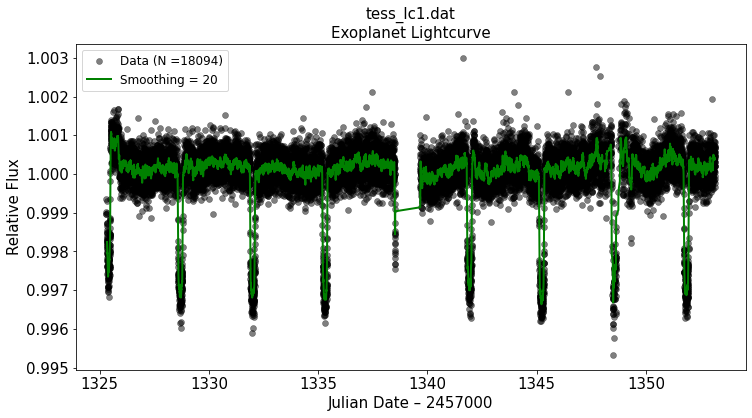

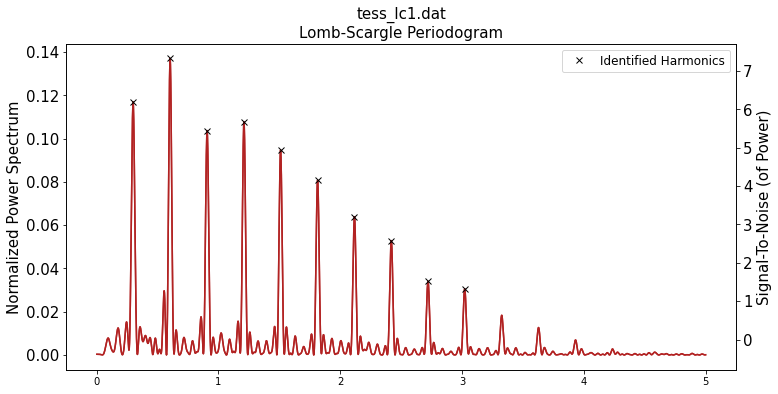

/home/afinemax/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


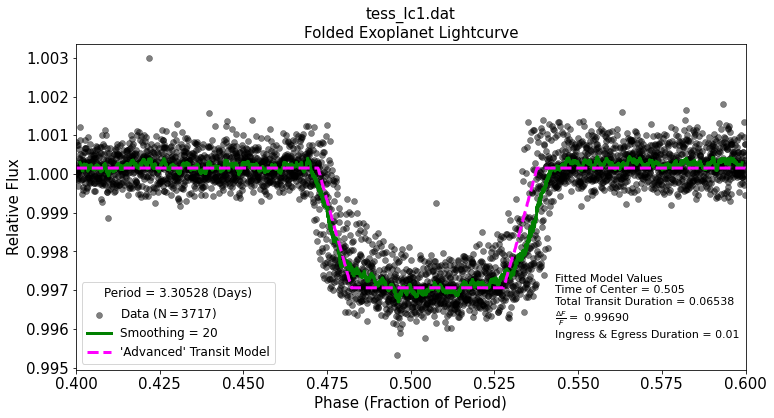

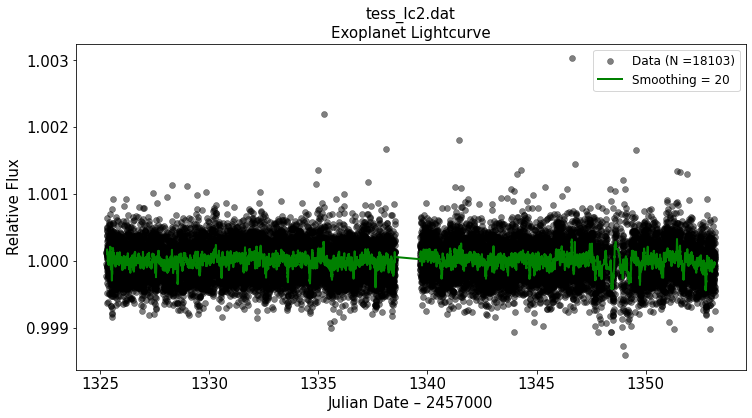

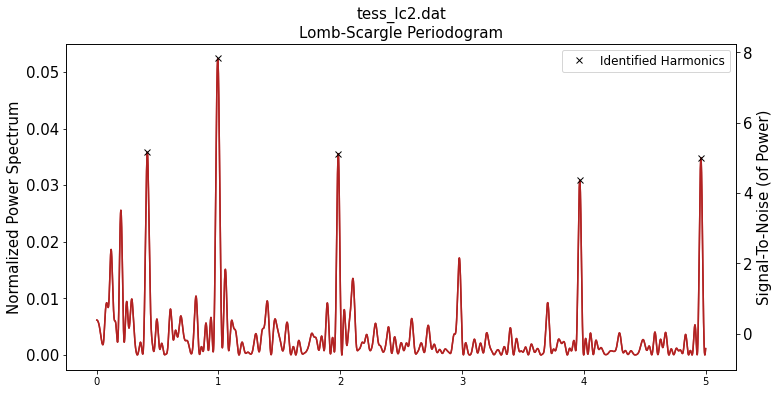

No Exoplanet Found in tess_lc2.dat
 :(( Better Luck Next Time!


In [6]:
# this produces 6 plots, 3 for each data file. The plots are labeled with which data file
boxcar_length = 20
for exoplanet_data in [data_file01, data_file02]: 
    period, popt, pcov = find_exoplanet(exoplanet_data, boxcar_length, make_plot=True,)
